# Discontinuity Analysis

In [114]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
sns.set(style="whitegrid")

# Show data without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Kernel weighted RD

In [105]:
class Kernels:
    def __init__(self):
        pass
        

    # Triangular kernel
    def triangular_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (1 - np.abs(R - c) / h)
    
    # Epanechnikov kernel
    def epanechnikov_kernel(R, c, h):
        indicator = (np.abs(R - c) <= h).astype(float)
        return indicator * (3/4) * (1 - ((R - c) / h) ** 2)
    

# Plotting Dataframe Generation

In [122]:
# Generate Plotting Dataframe
def generate_plotting_df(data):
    cutoff = 0
    bandwidth = 10000
    bin_size = 20

    # Filter out the outliers
    plotting_df = data.copy()
    plotting_df = plotting_df[(plotting_df['dollars_to_goal'] <= bandwidth) & (plotting_df['dollars_to_goal'] >= -bandwidth)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'raised_next_usd': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'raised_next_usd': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)
    return plotting_df

# Load the Data

In [108]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328652, 148)

Define Running Variable

In [109]:
# Calculate the dollars to goal
df['dollars_to_goal'] = df['usd_pledged']  - df['usd_goal']

# Create threshold Variable
df = df.assign(threshold = (df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)

# Calculate the dollars to goal times threshold
df['dollars_to_goal*threshold'] = df['dollars_to_goal'] * df['threshold']

# Quadtratic term
df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']

# Key Statistics

In [110]:
# Check success next statistics
df[['usd_goal', 'usd_pledged', 'dollars_to_goal', 'staff_pick', 'backers_count']].describe()

,usd_goal,usd_pledged,dollars_to_goal,staff_pick,backers_count
count,328652.000,328652.000,328652.000,321019.000,328652.000
mean,39749.071,12231.960,-27517.111,0.115,129.538
std,1049282.913,97368.424,1053242.408,0.319,936.501
min,0.511,0.000,-152350076.000,0.000,0.000
25%,2000.000,73.214,-7000.000,0.000,3.000
50%,5000.000,1228.000,-50.000,0.000,21.000
75%,15000.000,6055.000,620.993,0.000,77.000
max,152350076.000,13285226.360,13235226.360,1.000,219382.000


In [111]:
# Replace nas with 0
filled_df = df.copy()
filled_df['success_next'] = filled_df['success_next'].fillna(0)

# Generate Plotting Dataframe

In [ ]:
plotting_df = generate_plotting_df(df)

In [ ]:
# Describe success_next
plotting_df


## Plot Next Project Success by Dollars to Goal

In [ ]:
cutoff = 0
plt.figure()
plt.plot(plotting_df['dollars_to_goal'], plotting_df['success_next'], 'o')
plt.axvline(x=cutoff, color='r', linestyle='--')
plt.xlabel('Dollars to goal')
plt.ylabel('Probability of Next Project Success')
plt.title('Probability of Next Project Success by Dollars to Goal')

# Effect on Success Next

## Naive Model

Drop NAs from Main Dataframe

In [112]:
# Create df with no NAs in success_next
ml_df = df.dropna(subset=['success_next'])

In [ ]:

# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['success_next']

model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

In [ ]:
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                family = sm.families.Binomial(), 
                data = df).fit()

table_model.summary()


In [ ]:
# Get the percent change in probability from log odds
print(f"Threshold Parameter: {model.coef_[0,1]:.5f}")
probability = np.exp(model.coef_[0,1]) - 1
print(f"Change in probability of success: {probability:.2f}%")

In [ ]:
plotting_df = generate_plotting_df(df)

In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success.png')
plt.show()


## Including Quitters

In [ ]:
plotting_df = generate_plotting_df(filled_df)

In [ ]:
# Create threshold Variable
filled_df = filled_df.assign(threshold = (filled_df['dollars_to_goal'] > 0).astype(int)).sort_values('dollars_to_goal').reset_index(drop=True)
# Calculate the dollars to goal times threshold
filled_df['dollars_to_goal*threshold'] = filled_df['dollars_to_goal'] * filled_df['threshold']

In [ ]:
X = filled_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = filled_df['success_next']

model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success.png')
plt.show()


## RD with Kernel

In [ ]:
bandwidth = 10000
plt.plot(sorted(ml_df["dollars_to_goal"]), Kernels.triangular_kernel(ml_df["dollars_to_goal"], c=cutoff, h=bandwidth), label="Triangular Kernel")
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-bandwidth, bandwidth)
plt.title("Kernel Weight by Goal Percentage");

In [ ]:
X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], ml_df['success_next']
cutoff = 0
bandwidth = 10000
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(ml_df['dollars_to_goal'], c=cutoff, h=bandwidth))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

In [ ]:
cutoff = 0
bandwidth = 10000
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                family = sm.families.Binomial(), 
                data = df, 
                freq_weights = Kernels.triangular_kernel(df['dollars_to_goal'], c = cutoff, h = bandwidth)
                ).fit()

table_model.summary()


In [ ]:
plotting_df = generate_plotting_df(df)

In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success_with_kernel.png')
plt.show()


## RD with Controls and Weights

In [ ]:
weights = Kernels.triangular_kernel(df['dollars_to_goal'], c = cutoff, h = bandwidth)
weights[weights == 0] = 1e-10

all_categories = sorted(df['category_name'].unique())

model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name, levels=all_categories)', 
                family = sm.families.Binomial(), 
                data = df, 
                freq_weights = weights).fit()

model.summary().tables[1]


## RD with Quadratic

In [ ]:
table_model = smf.glm('success_next ~ dollars_to_goal + dollars_to_goal_2 + threshold + dollars_to_goal*threshold + dollars_to_goal_2*threshold', 
                family = sm.families.Binomial(), 
                data = df
                ).fit()

table_model.summary()


## RD with IK and CCT Bandwidth

In [ ]:
from rdd import rdd

In [ ]:
ik_bandwidth = rdd.optimal_bandwidth(X = ml_df['dollars_to_goal'], Y = ml_df['success_next'], cut = 0)
print(f"Imbens-Kalyanaraman Optimal Bandwidth: {ik_bandwidth:.2f}")

In [ ]:
bandwidth_data = rdd.truncated_data(ml_df, xname = 'dollars_to_goal', bandwidth=ik_bandwidth, yname = 'success_next', cut = 0)

# Print data shape based on dollars_to_goal variable less than 0 and greater than or equal to 0
print(f"Data Shape: {bandwidth_data.shape}")
print(f"Before Cutoff Data Shape: {bandwidth_data[bandwidth_data['dollars_to_goal'] < 0].shape}")
print(f"After Cutoff Data Shape: {bandwidth_data[bandwidth_data['dollars_to_goal'] >= 0].shape}")

bandwidth_data

In [ ]:
X, y = bandwidth_data[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], bandwidth_data['success_next']
cutoff = 0
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(bandwidth_data['dollars_to_goal'], c=cutoff, h=ik_bandwidth))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

In [ ]:
table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold ', 
                family = sm.families.Binomial(), 
                data = bandwidth_data,
                freq_weights = Kernels.triangular_kernel(bandwidth_data['dollars_to_goal'], c = cutoff, h = ik_bandwidth)
                ).fit()

table_model.summary()


In [ ]:
plotting_df = generate_plotting_df(ml_df)

In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

#plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_campaign_success_with_kernel.png')
plt.show()


CCT Bandwidth

In [ ]:
from rdrobust import rdbwselect

In [ ]:
print(rdbwselect(y=df['success_next'], x=df['dollars_to_goal'], all=True))

In [ ]:
bandwidth_cct = 18349.535

X, y = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']], ml_df['success_next']
cutoff = 0
model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y, sample_weight=Kernels.triangular_kernel(ml_df['dollars_to_goal'], c=cutoff, h=bandwidth_cct))

# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_[0,:], model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict


In [ ]:
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth_cct)
weights[weights == 0] = 1e-10

table_model = smf.glm('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold ', 
                family = sm.families.Binomial(), 
                data = ml_df,
                freq_weights = weights
                ).fit()

table_model.summary()


In [ ]:
plotting_df = generate_plotting_df(ml_df)

In [ ]:
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict_proba(exog_dict)[:,1]
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 0, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/cct_bandwidth_next_kickstarter_success.png')
plt.show()


# Raised Next

## Naive Model

In [ ]:
# Fit the model
X = ml_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
y = ml_df['raised_next_usd']


model = LinearRegression(fit_intercept=True).fit(X,y)


# Print param names and coefficients
coef_dict = {}
for coef, feat in zip(model.coef_, model.feature_names_in_):
    coef_dict[feat] = "{:.10f}".format(coef)

coef_dict

{'dollars_to_goal': '-0.0000041166',
 'threshold': '4708.6911492285',
 'dollars_to_goal*threshold': '1.0082288861'}

In [133]:
table_model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df).fit()

table_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        raised_next_usd   R-squared:                       0.331
Model:                            WLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     7472.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:37:55   Log-Likelihood:            -6.1951e+05
No. Observations:               45300   AIC:                         1.239e+06
Df Residuals:                   45296   BIC:                         1.239e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3724.7938   1656.244      2.249      0.025     478.528    6971.060
dollars_to_goal           -4.117e-06      0.001     -0.006      0.996      -0.001       0.001
threshold                  4708.6911   2072.151      2.272      0.023     647.241    8770.142
dollars_to_goal:threshold     1.0082      0.007    148.119      0.000       0.995       1.022
==============================================================================
Omnibus:                   183187.232   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     571088110755.807
Skew:                         105.572   Prob(JB):                         0.00
Kurtosis:                   17396.063   Cond. No.                     3.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\d0tam\AppData\Local\Temp\ipykernel_34056\3626772908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\d0tam\AppData\Local\Temp\ipykernel_34056\3626772908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


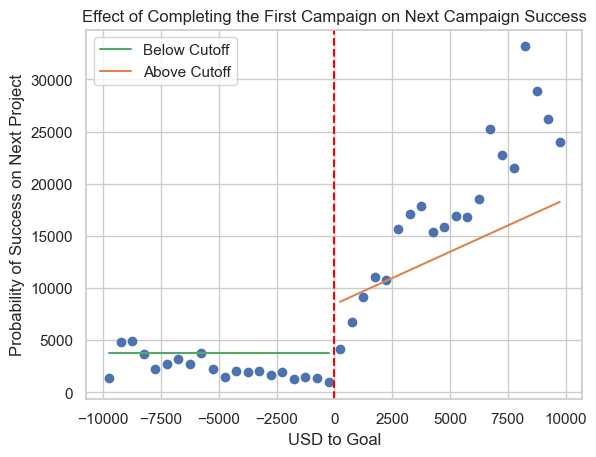

In [134]:
plotting_df = generate_plotting_df(df)
# Remove outliers
plt.figure()
plt.scatter(plotting_df['dollars_to_goal'], plotting_df['raised_next_usd'], color = "C0")
#ax = plotting_df.plot.scatter(x = 'dollars_to_goal', y = 'success_next', color = "C0")

# Create threshold and Interaction Variable
cutoff = 0
plotting_df['threshold'] = 0
plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1

# Convert threshold to int
plotting_df['threshold'] = plotting_df['threshold'].astype(int)
plotting_df['dollars_to_goal*threshold'] = plotting_df['dollars_to_goal'] * plotting_df['threshold']

exog_dict = plotting_df[['dollars_to_goal', 'threshold', 'dollars_to_goal*threshold']]
plotting_df['predictions'] = model.predict(exog_dict)
left_plotting_df = plotting_df[plotting_df['dollars_to_goal'] < cutoff]
right_plotting_df = plotting_df[plotting_df['dollars_to_goal'] >= cutoff]
plt.plot(left_plotting_df['dollars_to_goal'], left_plotting_df['predictions'], color = 'C2', label = 'Below Cutoff')
plt.plot(right_plotting_df['dollars_to_goal'], right_plotting_df['predictions'], color = 'C1', label = 'Above Cutoff')
plt.legend()
plt.axvline(x = 1, color = 'red', linestyle = '--')
plt.ylabel('Probability of Success on Next Project')
plt.xlabel('USD to Goal')
plt.title('Effect of Completing the First Campaign on Next Campaign Success')

plt.savefig('../images/next_kickstarter/effect_of_completing_the_first_campaign_on_next_raised.png')
plt.show()


## Triangular Kernel

In [138]:
c = 0
bandwidth = 10000
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth)

table_model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold', 
                data = ml_df,
                weights = weights).fit()

table_model.summary()



c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        raised_next_usd   R-squared:                       0.034
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     538.7
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:43:22   Log-Likelihood:                   -inf
No. Observations:               45300   AIC:                               inf
Df Residuals:                   45296   BIC:                               inf
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1189.0191    343.346      3.463      0.001     516.054    1861.984
dollars_to_goal              -0.2527      0.115     -2.199      0.028      -0.478      -0.027
threshold                  3051.1129    383.286      7.960      0.000    2299.866    3802.359
dollars_to_goal:threshold     3.2949      0.147     22.486      0.000       3.008       3.582
==============================================================================
Omnibus:                   119401.017   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3825742896.045
Skew:                          31.242   Prob(JB):                         0.00
Kurtosis:                    1425.315   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Kernel and Controls

In [140]:
weights = Kernels.triangular_kernel(ml_df['dollars_to_goal'], c = cutoff, h = bandwidth)
weights[weights == 0] = 1e-10

all_categories = sorted(ml_df['category_name'].unique())

model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold + goal + backers_count + staff_pick + prelaunch_activated + C(category_name, levels=all_categories)', 
                data = ml_df, 
                weights = weights).fit()

model.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7194.8529,2190.719,3.284,0.001,2900.828,1.15e+04
"C(category_name, levels=all_categories)[T.Academic]",-6226.5175,2879.242,-2.163,0.031,-1.19e+04,-582.921
"C(category_name, levels=all_categories)[T.Accessories]",-8571.3716,2394.556,-3.580,0.000,-1.33e+04,-3877.806
"C(category_name, levels=all_categories)[T.Action]",-7069.6763,3205.596,-2.205,0.027,-1.34e+04,-786.394
"C(category_name, levels=all_categories)[T.Animals]",-8463.5894,4221.235,-2.005,0.045,-1.67e+04,-189.554
"C(category_name, levels=all_categories)[T.Animation]",-5084.3042,2608.543,-1.949,0.051,-1.02e+04,28.696
"C(category_name, levels=all_categories)[T.Anthologies]",-9292.2011,2356.623,-3.943,0.000,-1.39e+04,-4672.988
"C(category_name, levels=all_categories)[T.Apparel]",-2795.7543,2623.457,-1.066,0.287,-7937.987,2346.479
"C(category_name, levels=all_categories)[T.Apps]",-9483.5433,3545.426,-2.675,0.007,-1.64e+04,-2534.159
"C(category_name, levels=all_categories)[T.Architecture]",-6725.8894,3776.103,-1.781,0.075,-1.41e+04,675.644


## Quadratic

In [144]:
model = smf.wls('raised_next_usd ~ dollars_to_goal + threshold + dollars_to_goal*threshold + dollars_to_goal_2 + dollars_to_goal_2*threshold', 
                data = ml_df).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        raised_next_usd   R-squared:                       0.356
Model:                            WLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     4997.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:48:08   Log-Likelihood:            -6.1867e+05
No. Observations:               45300   AIC:                         1.237e+06
Df Residuals:                   45294   BIC:                         1.237e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    3711.4010   1628.611      2.279      0.023     519.297    6903.505
dollars_to_goal                -0.0003      0.002     -0.132      0.895      -0.005       0.004
threshold                    1.199e+04   2043.820      5.867      0.000    7984.682     1.6e+04
dollars_to_goal:threshold       0.6165      0.012     52.417      0.000       0.593       0.640
dollars_to_goal_2           -2.761e-12   2.01e-11     -0.137      0.891   -4.22e-11    3.67e-11
dollars_to_goal_2:threshold  8.375e-08   2.02e-09     41.458      0.000    7.98e-08    8.77e-08
==============================================================================
Omnibus:                   179334.753   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     525470852189.856
Skew:                          98.568   Prob(JB):                         0.00
Kurtosis:                   16687.013   Cond. No.                     3.77e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [145]:
print(model.params)

Intercept                      3711.401
dollars_to_goal                  -0.000
threshold                     11990.603
dollars_to_goal:threshold         0.617
dollars_to_goal_2                -0.000
dollars_to_goal_2:threshold       0.000
dtype: float64


# CATE

## Conditional on Next Goal Intensity

Generate Intensity

In [ ]:
# Create new column for ratio of new goal to first goal
df['new_goal/old_goal'] = df['usd_goal_next'] / df['usd_goal']

# Create new column for intensity where intensity is low if it new_goal/old_goal is between 0 and 0.5, medium low if it is between 0.5 and 0.75, same if it is between 0.75 and 1.25, and high if it is greater than 1.25 
df['intensity'] = 'low'
df.loc[(df['new_goal/old_goal'] >= 0.25) & (df['new_goal/old_goal'] < 0.5), 'intensity'] = 'medium low'
df.loc[(df['new_goal/old_goal'] >= 0.50) & (df['new_goal/old_goal'] < 0.75), 'intensity'] = 'medium'
df.loc[(df['new_goal/old_goal'] >= 0.75) & (df['new_goal/old_goal'] < 1), 'intensity'] = 'average'
df.loc[df['new_goal/old_goal'] == 1, 'intensity'] = 'same'
df.loc[(df['new_goal/old_goal'] > 1) & (df['new_goal/old_goal'] < 1.25), 'intensity'] = 'above average'
df.loc[(df['new_goal/old_goal'] >= 1.25) & (df['new_goal/old_goal'] < 1.5), 'intensity'] = 'high'
df.loc[(df['new_goal/old_goal'] >= 1.5) & (df['new_goal/old_goal'] < 2), 'intensity'] = 'very high'
df.loc[df['new_goal/old_goal'] >= 2, 'intensity'] = 'extremely high'



In [ ]:
df['new_goal/old_goal'].describe()

In [ ]:
# Drop rows where success_next is NA
plot_intensity = df.dropna(subset=['success_next'])

# Ensure 'intensity' is a categorical column with a specified order
intensity_order = ['low', 'medium low', 'medium', 'average', 'same', 
                   'above average', 'high', 'very high', 'extremely high']
plot_intensity['intensity'] = pd.Categorical(plot_intensity['intensity'], categories=intensity_order, ordered=True)

# Plot using sns.barplot
plt.figure(figsize=(12, 6))
sns.countplot(data=plot_intensity, 
              x='intensity', 
              hue='success_next', 
              order=intensity_order)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Distribution of Intensity by Success Next')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility, if needed
plt.legend(title='Success in Next Campaign', loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Iterate through unique intensities and create models
for idx, i in enumerate(df['intensity'].unique()):
    # Ensure you don't exceed subplot limits
    if idx >= len(ax):
        print("Warning: More intensities than subplots available.")
        break

    intensity_df = df[df['intensity'] == i]
    plotting_df = intensity_df[(intensity_df['dollars_to_goal'] <= bandwidth) & (intensity_df['dollars_to_goal'] >= -bandwidth)]

    # Split data into left and right of the cutoff
    left_df = plotting_df[(plotting_df['state'] == 'failed') & (plotting_df['dollars_to_goal'] < cutoff)]
    right_df = plotting_df[(plotting_df['state'] == 'successful') & (plotting_df['dollars_to_goal'] >= cutoff)]

    # Bin each subset separately
    left_df['dollars_to_goal_binned'] = pd.cut(left_df['dollars_to_goal'], bins=bin_size)
    right_df['dollars_to_goal_binned'] = pd.cut(right_df['dollars_to_goal'], bins=bin_size)

    # Aggregate the binned data for each subset
    left_binned_data = left_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})
    right_binned_data = right_df.groupby('dollars_to_goal_binned', observed=False).agg({
        'success_next': 'mean',
        'goal': 'mean',
        'backers_count': 'mean',
        'staff_pick': 'mean',
        'prelaunch_activated': 'mean',
        'dollars_to_goal': 'size'  # Counts the number of observations in each bin
    }).reset_index().rename(columns={'dollars_to_goal': 'n_obs'})

    # Add a midpoint for each bin for both left and right data
    left_binned_data['dollars_to_goal'] = left_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)
    right_binned_data['dollars_to_goal'] = right_binned_data['dollars_to_goal_binned'].apply(lambda interval: interval.mid)

    # Combine the binned data for both sides of the cutoff
    plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)
    plotting_df['threshold'] = 0
    plotting_df.loc[plotting_df['dollars_to_goal'] > cutoff, 'threshold'] = 1
    # Fit the logistic regression model
    model = smf.logit('success_next ~ dollars_to_goal + threshold + dollars_to_goal*threshold', intensity_df).fit()
    print(f"Intensity: {i}")
    print(model.summary().tables[1])
    print("\n")

    # Plot the data and regression discontinuity
    ax[idx].scatter(plotting_df['dollars_to_goal'], plotting_df['success_next'], color="C0")
    ax[idx].plot(plotting_df['dollars_to_goal'], model.predict(plotting_df), color="C1")

    ax[idx].axvline(x=0, color='red', linestyle='--')
    ax[idx].set_title(f'Intensity: {i}')
    ax[idx].set_xlabel('Dollars to Goal')
    ax[idx].set_ylabel('Success Next')

# Adjust layout
plt.tight_layout()
plt.show()

# Models for Table

In [ ]:
# Create threshold square and cubic and their interactions
df['dollars_to_goal_2'] = df['dollars_to_goal'] ** 2
df['dollars_to_goal_3'] = df['dollars_to_goal'] ** 3
df['dollars_to_goal_2*threshold'] = df['dollars_to_goal_2'] * df['threshold']
df['dollars_to_goal_3*threshold'] = df['dollars_to_goal_3'] * df['threshold']


Formulas

In [ ]:
model1 = ['threshold', 'dollars_to_goal']
model2 = ['threshold', 'dollars_to_goal', 'dollars_to_goal*threshold']
model3 = ['threshold', 'dollars_to_goal', 'dollars_to_goal_2']
model4 = ['threshold', 'dollars_to_goal', 'dollars_to_goal_2', 'dollars_to_goal*threshold', 'dollars_to_goal_2*threshold']


models = [model1, model2, model3, model4]

Model

In [ ]:
for i in models:
    X, y = ml_df[X], ml_df['success_next']
    model = LogisticRegression(fit_intercept=True, verbose = 1).fit(X,y)
    print(f"Model: {i}")
    print(f"Threshold Parameter: {model.coef_[0,1]:.5f}")